# TensorFlow Assignment: Multilayer Perceptron (MLP) Optimizer Sandbox

**[Duke Community Standard](http://integrity.duke.edu/standard.html): By typing your name below, you are certifying that you have adhered to the Duke Community Standard in completing this assignment.**

Name: [Jinwei Wan]

## Multilayer Perceptron (MLP)

### Imports and helper functions

Let's play around with some optimizers. First some imports and helper functions:

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# Import data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Helper functions for creating weight variables
def weight_variable(shape):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

### Models

And here's the forward pass of the computation graph definition of the completed TensorFlow MLP assignment:

In [3]:
# Convolutional neural network functions
def conv2d(x, W):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    """max_pool_2x2 downsamples a feature map by 2X."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Tensorflow Function that might also be of interest:
# tf.reshape()

In [6]:
# Model Inputs
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

w_conv1 = weight_variable([5,5,1,16]) 
#b_conv1 = bias_variable([32])
w_conv2 = weight_variable([5,5,16,32]) 
#b_conv2 = bias_variable([64])
w_fc3 = weight_variable([7*7*32,1024]) 
b_fc3 = bias_variable([1024])
w_o = weight_variable([1024,10]) 
b_o = bias_variable([10])
def conv_homework(x,w_conv1,w_conv2,w_fc3,b_fc3,w_o,b_o):
    x_image = tf.reshape(x, [-1,28,28,1])# 28*28*1
    h1_conv = conv2d(x_image, w_conv1) # 28*28*32
    h1_pool = max_pool_2x2(h1_conv)# 14*14*32
    h2_conv = conv2d(h1_pool, w_conv2)# 14*14*64
    h2_pool = max_pool_2x2(h2_conv)# 7*7*64
    h2_pool_flat = tf.reshape(h2_pool, [-1, 7*7*32])# reshape
    h3_fc = tf.nn.relu(tf.matmul(h2_pool_flat, w_fc3) + b_fc3) # 
    pyx = tf.matmul(h3_fc, w_o) + b_o
    return pyx # note that we dont take the softmax at the end because our cost fn does that for us

y_mlp = conv_homework(x,w_conv1,w_conv2,w_fc3,b_fc3,w_o,b_o)

# Loss 
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_mlp))

# Evaluation
correct_prediction = tf.equal(tf.argmax(y_mlp, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Optimizers

Instead of the optimizer being given though, let's try out a few. Here we have optimizers implementing algorithms for [Stochastic Gradient Descent](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer) (SGD), [Stochastic Gradient Descent with Momentum](https://www.tensorflow.org/api_docs/python/tf/train/MomentumOptimizer) (momentum), and [Adaptive Moments](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) (ADAM). Try out different parameter settings (e.g. learning rate) for each of them.

In [7]:
# Optimizers: Try out a few different parameters for SGD and SGD momentum
train_step_SGD = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cross_entropy)
train_step_momentum = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.9).minimize(cross_entropy)
train_step_ADAM = tf.train.AdamOptimizer().minimize(cross_entropy)

# Op for initializing all variables
initialize_all = tf.global_variables_initializer()

### Training

Because we'll be repeating training a few times, let's move our training regimen into function. Note that we pass which optimization algorithm we're running as an argument. In addition to printing out the validation accuracy and final test accuracy, we'll also return the lists of accuracies at each validation step and the training losses at each iteration.

In [8]:
def train_MLP(train_step_optimizer, iterations=4000):
    with tf.Session() as sess:
        # Initialize (or reset) all variables
        sess.run(initialize_all)
        
        # Initialize arrays to track losses and validation accuracies
        valid_accs = [] 
        losses = []
        
        for i in range(iterations):
            # Validate every 250th batch
            if i % 250 == 0:
                validation_accuracy = 0
                for v in range(10):
                    batch = mnist.validation.next_batch(50)
                    validation_accuracy += (1/10.) * accuracy.eval(feed_dict={x: batch[0], y_: batch[1]})
                print('step %d, validation accuracy %g' % (i, validation_accuracy))
                valid_accs.append(validation_accuracy)
                
            # Train    
            batch = mnist.train.next_batch(50)
            loss, _ = sess.run([cross_entropy, train_step_optimizer], feed_dict={x: batch[0], y_: batch[1]})
            losses.append(loss)
            
        print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))
        
    return valid_accs, losses

Finally, let's train the MLP using all three optimizers and compare the results:

In [9]:
print("SGD:")
valid_accs_SGD, losses_SGD = train_MLP(train_step_SGD)
print("Momentum:")
valid_accs_momentum, losses_momentum = train_MLP(train_step_momentum)
print("ADAM:")
valid_accs_ADAM, losses_ADAM = train_MLP(train_step_ADAM)

SGD:
step 0, validation accuracy 0.078
step 250, validation accuracy 0.912
step 500, validation accuracy 0.93
step 750, validation accuracy 0.946
step 1000, validation accuracy 0.968
step 1250, validation accuracy 0.966
step 1500, validation accuracy 0.962
step 1750, validation accuracy 0.978
step 2000, validation accuracy 0.966
step 2250, validation accuracy 0.978
step 2500, validation accuracy 0.972
step 2750, validation accuracy 0.98
step 3000, validation accuracy 0.974
step 3250, validation accuracy 0.972
step 3500, validation accuracy 0.978
step 3750, validation accuracy 0.978
test accuracy 0.9747
Momentum:
step 0, validation accuracy 0.146
step 250, validation accuracy 0.94
step 500, validation accuracy 0.972
step 750, validation accuracy 0.97
step 1000, validation accuracy 0.964
step 1250, validation accuracy 0.976
step 1500, validation accuracy 0.99
step 1750, validation accuracy 0.988
step 2000, validation accuracy 0.982
step 2250, validation accuracy 0.986
step 2500, validati

### Visualization

Plotting things:

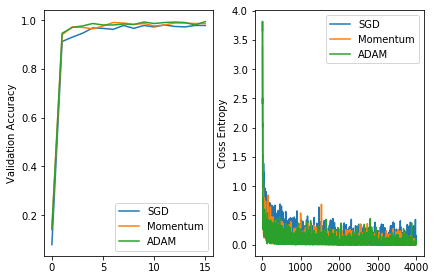

In [10]:
fig, ax = plt.subplots(1, 2)
fig.tight_layout()

ax[0].plot(valid_accs_SGD)
ax[0].plot(valid_accs_momentum)
ax[0].plot(valid_accs_ADAM)

ax[0].set_ylabel('Validation Accuracy')
ax[0].legend(['SGD', 'Momentum', 'ADAM'], loc='lower right')

ax[1].plot(losses_SGD)
ax[1].plot(losses_momentum)
ax[1].plot(losses_ADAM)

ax[1].set_ylabel('Cross Entropy')
ax[1].legend(['SGD', 'Momentum', 'ADAM'], loc='upper right')
# ax[1].set_ylim([0,1.5])  # <- Use this to change y-axis limits

### Short Answer

How do SGD, SGD with momentum, and ADAM compare in performance? Ease of tuning parameters?

***
For CNN case:
Accuracy: ADAM = SGDmoment(0.01,0.9) > SGD(0.01)

***

## Convolutional Neural Network (CNN): *Optional*

Adapt the MLP code above to train a CNN instead (*Hint: you can adapt the code from the 01D_MLP_CNN_Assignment_Solutions.ipynb for the CNN just like I did for the MLP*), and again compare the optimizers. The more complex nature of the CNN parameter space means that the differences between optimizers should be much more significant.